In [89]:
import pandas as pd
import numpy as np
from datetime import datetime as dt


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG,display
from graphviz import Source

In [90]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/SeoulBikeData - SeoulBikeData.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
df_new = df.copy()

df_new.rename(columns= {'Date':'date','Rented Bike Count': 'rented_bike_count', 'Hour':'hour',
                    'Temperature(蚓)':'temperature', 'Humidity(%)':'humidity',
                    'Wind speed (m/s)': 'wind_speed', 'Visibility (10m)': 'visibility',
                    'Dew point temperature(蚓)':'dew_point_temp',
                    'Solar Radiation (MJ/m2)': 'solar_radiation', 'Rainfall(mm)': 'rainfall',
                    'Snowfall (cm)':'snowfall', 'Seasons':'seasons',
                    'Holiday':'holiday', 'Functioning Day':'func_day'},
          inplace=True)

df_new.columns

Index(['date', 'rented_bike_count', 'hour', 'temperature', 'humidity',
       'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation',
       'rainfall', 'snowfall', 'seasons', 'holiday', 'func_day'],
      dtype='object')

In [92]:
df_new['date'] = df_new['date'].apply(lambda x: dt.strptime(x,'%d/%m/%Y'))
df_new.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,seasons,holiday,func_day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [79]:
df_new['month'] = df_new['date'].apply(lambda x : x.month)
df_new['day_of_week'] = df_new['date'].apply(lambda x : x.isoweekday())
df_new['year'] = df_new['date'].apply(lambda x : x.year)
df_new.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,seasons,holiday,func_day,month,day_of_week,year
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017


In [80]:
df_new.drop('date', axis=1, inplace = True)
df_new.head()

,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,seasons,holiday,func_day,month,day_of_week,year
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,5,2017


In [81]:
df_new['snowfall'] = df_new['snowfall'].apply(lambda x: 1 if x>0 else 0)
df_new['rainfall'] = df_new['rainfall'].apply(lambda x: 1 if x>0 else 0)
df_new['visibility'] = df_new['visibility'].apply(lambda x: 0 if 0<=x<=399 else (1 if 400<=x<=999 else 2))
df_new['func_day'] = np.where(df_new['func_day'] == 'Yes',1,0)
df_new['holiday'] = np.where(df_new['holiday'] == 'Holiday',1,0)
df_new['seasons'] = df_new['seasons'].map({'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3})
df_new.head()

,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,seasons,holiday,func_day,month,day_of_week,year
0,254,0,-5.2,37,2.2,2,-17.6,0.0,0,0,0,0,1,12,5,2017
1,204,1,-5.5,38,0.8,2,-17.6,0.0,0,0,0,0,1,12,5,2017
2,173,2,-6.0,39,1.0,2,-17.7,0.0,0,0,0,0,1,12,5,2017
3,107,3,-6.2,40,0.9,2,-17.6,0.0,0,0,0,0,1,12,5,2017
4,78,4,-6.0,36,2.3,2,-18.6,0.0,0,0,0,0,1,12,5,2017


In [65]:
df1 = df_new
df2 = df_new

PCA and kBest

In [14]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Assuming df_new is your DataFrame
# If not, replace df_new with your actual DataFrame

# Extracting features and target variable
X = df_new.drop('rented_bike_count', axis=1)  # Features
y = df_new['rented_bike_count']  # Target variable

# Standardize the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
num_components = min(X.shape[0], X.shape[1])  # Number of components is minimum of rows and columns
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)

# Display the explained variance ratio for each principal component
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Perform feature selection using SelectKBest
k_best = SelectKBest(f_regression, k=12)  # Adjust the value of k as needed
X_selected = k_best.fit_transform(X_scaled, y)

# Display selected features
selected_features = X.columns[k_best.get_support()]
print("Selected Features:")
print(selected_features)

Explained Variance Ratio:
[0.20937425 0.15604197 0.10446075 0.08223972 0.07036052 0.06524249
 0.06371618 0.05790437 0.05170661 0.04924466 0.03885301 0.03501023
 0.01440094 0.00115364 0.00029067]
Selected Features:
Index(['hour', 'temperature', 'humidity', 'visibility', 'dew_point_temp',
       'solar_radiation', 'rainfall', 'snowfall', 'seasons', 'func_day',
       'month', 'year'],
      dtype='object')


y sqrt

In [33]:
sf = ['hour', 'temperature', 'humidity', 'visibility', 'dew_point_temp',
       'solar_radiation', 'rainfall', 'snowfall', 'seasons', 'func_day',
       'month', 'year']
df = df_new[sf]

In [34]:
y = np.sqrt(df_new[['rented_bike_count']])

In [35]:
X_train, X_test, y_train, y_test = train_test_split( df, y, test_size = 0.3, random_state = 0)

In [36]:
# Defining a function to print evaluation matrix
def evaluate_model(model, y_test, y_pred):

  '''takes model, y test and y pred values to print evaluation metrics, plot the actual and predicted values,
  plot the top 20 important features, and returns a list of the model scores'''

  # Squring the y test and and pred as we have used sqrt transformation
  y_t = np.square(y_test)
  y_p = np.square(y_pred)
  y_train2 = np.square(y_train)
  y_train_pred = np.square(model.predict(X_train))

  # Calculating Evaluation Matrix
  mse = mean_squared_error(y_t,y_p)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_t,y_p)
  r2_train = r2_score(y_train2, y_train_pred)
  r2 = r2_score(y_t,y_p)
  r2_adjusted = 1-(1-r2)*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))

  # Printing Evaluation Matrix
  print("MSE :" , mse)
  print("RMSE :" ,rmse)
  print("MAE :" ,mae)
  print("Train R2 :" ,r2_train)
  print("Test R2 :" ,r2)
  print("Adjusted R2 : ", r2_adjusted)


  # plot actual and predicted values
  plt.figure(figsize=(13,4))
  plt.plot((y_p)[:100])
  plt.plot((np.array(y_t)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.title('Actual and Predicted Bike Count', fontsize=15)

  model_score = [mse,rmse,mae,r2_train,r2,r2_adjusted]
  return model_score



score = pd.DataFrame(index = ['MSE', 'RMSE', 'MAE', 'Train R2', 'Test R2', 'Adjusted R2'])

MSE : 166184.04770197076
RMSE : 407.6567768380292
MAE : 274.77732402251
Train R2 : 0.5899621928535044
Test R2 : 0.5926269349643553
Adjusted R2 :  0.5907575365779585


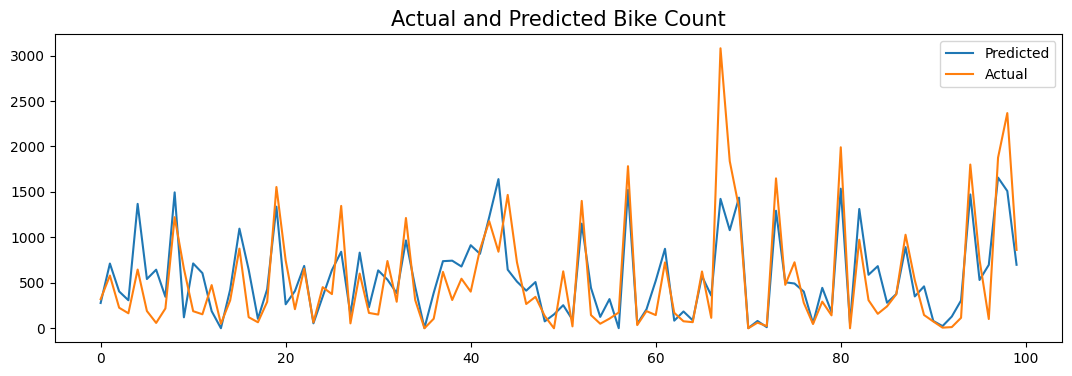

In [37]:
# Import the LinearRegression class
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_li = reg.predict(X_test)


# Visualizing evaluation Metric Score chart
linear_score = evaluate_model(reg, y_test,y_pred_li)
# Evaluation Metric Score chart
score['Linear regression'] = linear_score

MSE : 225773.50395364303
RMSE : 475.15629423763613
MAE : 328.47875353454356
Train R2 : 0.44553805036410254
Test R2 : 0.44655311035403245
Adjusted R2 :  0.44401339231359205


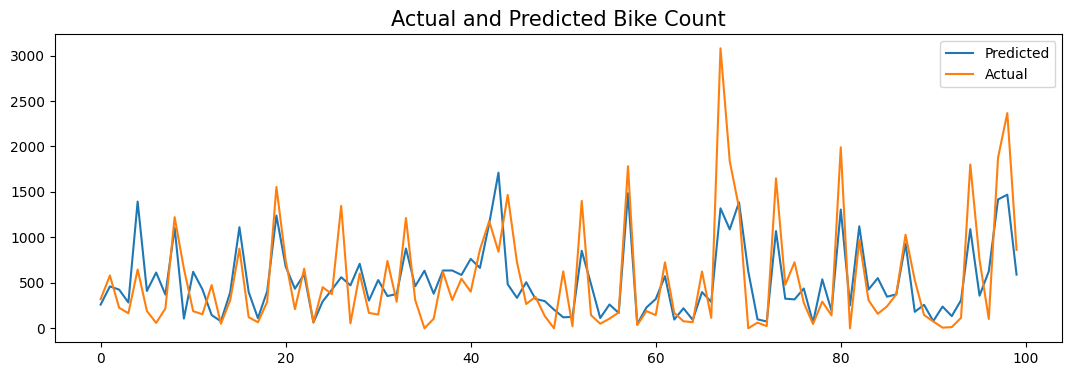

In [38]:
#Lasso regression
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso1 = lasso.predict(X_test)

lasso_score = evaluate_model(lasso, y_test,y_pred_lasso1)
score['Lasso regression'] = lasso_score

The optimum alpha value is found out to be : {'alpha': 0.001}

Using  {'alpha': 0.001}  the negative mean squared error is:  -50.99297107251873
MSE : 166245.27457288277
RMSE : 407.7318660258023
MAE : 274.75888976193664
Train R2 : 0.5897712759494891
Test R2 : 0.5924768472849968
Adjusted R2 :  0.5906067601597272


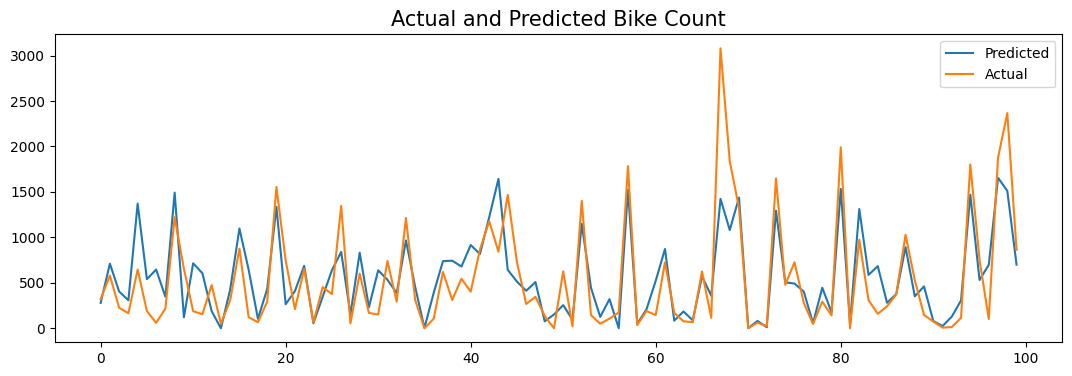

In [39]:
# Define the model
lasso = Lasso()

# Define the parameters to be optimized & Perform grid search
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

# Fitting model
lasso_regressor.fit(X_train,y_train)


# Getting optimum parameters
print("The optimum alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

# Import the Lasso Regression class with best alpha
lasso = Lasso(alpha = lasso_regressor.best_params_['alpha'])

# Fit the lasso regression model to your training data
lasso.fit(X_train, y_train)

# Predict the model
y_pred_lassocv = lasso.predict(X_test)

#Evaluation matrices for Lasso regression
lasso2 = evaluate_model(lasso, y_test,y_pred_lassocv)

name = 'Lasso with alpha = ' + str(lasso_regressor.best_params_['alpha'])

score[name] = lasso2

MSE : 166267.26814610473
RMSE : 407.75883576705576
MAE : 274.758953457128
Train R2 : 0.5896940029254116
Test R2 : 0.592422933630477
Adjusted R2 :  0.5905525991002918


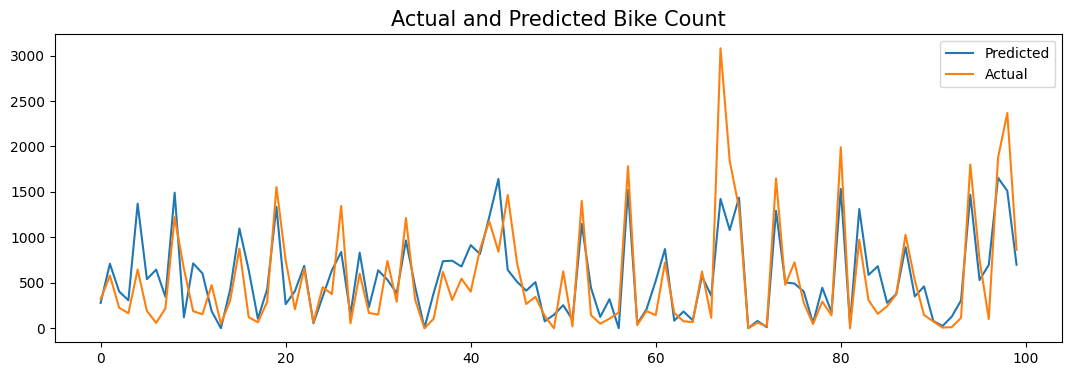

In [40]:
ridge = Ridge()

# Fit the ridge regression model to your training data
ridge.fit(X_train, y_train)

# Predict on the model
y_pred_ridge1 = ridge.predict(X_test)

result = evaluate_model(ridge, y_test,y_pred_ridge1)
score['Ridge'] = result

MSE : 92450.11136797041
RMSE : 304.0560990474791
MAE : 175.4190596368576
Train R2 : 0.9999975336408012
Test R2 : 0.773373643549722
Adjusted R2 :  0.7723336755660114


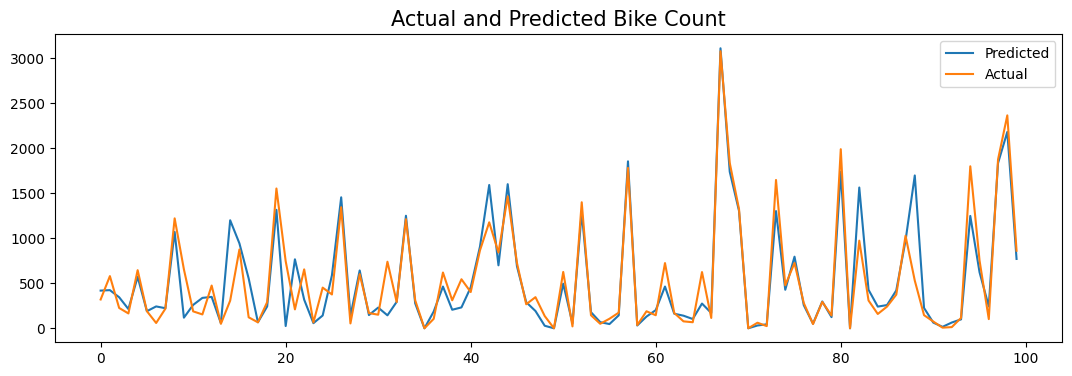

In [41]:
dt = DecisionTreeRegressor(random_state=1)

# Fit the Decision Tree model to your training data
dt.fit(X_train,y_train)

# Predict on the model
y_pred_dt = dt.predict(X_test)

result = evaluate_model(dt, y_test,y_pred_dt)
score['Decision tree'] = result

MSE : 52450.49956521079
RMSE : 229.02074046952777
MAE : 139.22805771256552
Train R2 : 0.9827873379549439
Test R2 : 0.871426162342312
Adjusted R2 :  0.8708361485557374


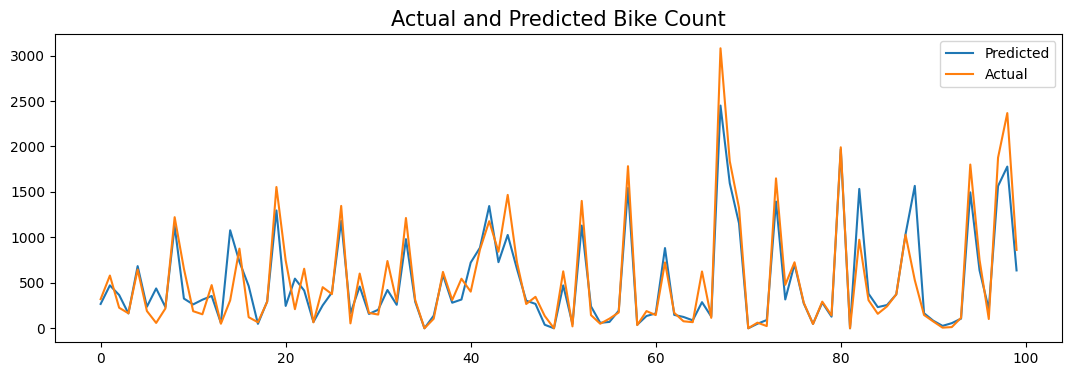

In [42]:
rf = RandomForestRegressor(random_state=0)

# Fit the Random Forest model to your training data
rf.fit(X_train,y_train)

# Predict on the model
y_pred_rf1 = rf.predict(X_test)

result = evaluate_model(rf, y_test,y_pred_rf1)
score['Random forest'] = result

MSE : 61963.358553194084
RMSE : 248.92440328982227
MAE : 154.94926144439907
Train R2 : 0.8644425600947513
Test R2 : 0.8481069414136194
Adjusted R2 :  0.8474099178178119


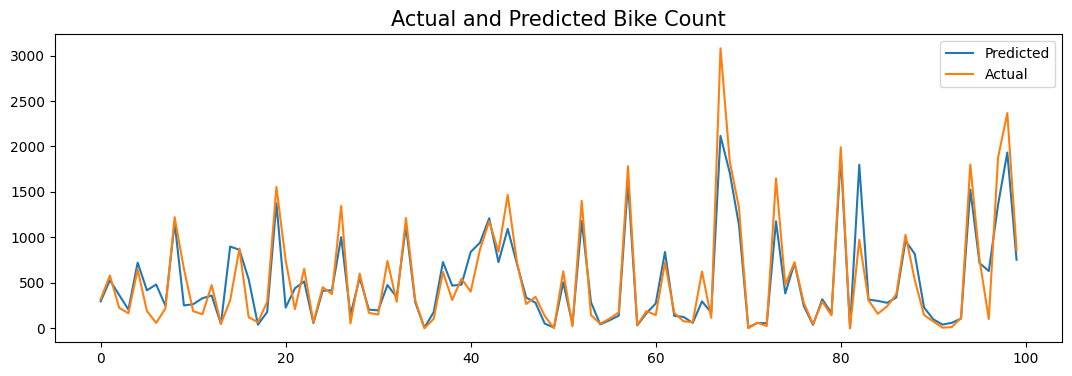

In [43]:
gb = GradientBoostingRegressor(random_state=0)

# Fit the Gradient Boosting model to the training data
gb.fit(X_train,y_train)

# Predict on the model
y_pred_gb1 = gb.predict(X_test)


result = evaluate_model(gb, y_test,y_pred_gb1)
score['Gradient Boosting Regressor'] = result

MSE : 51019.38368309914
RMSE : 225.8747079314086
MAE : 136.82692775394764
Train R2 : 0.9695683069787906
Test R2 : 0.8749343093117644
Adjusted R2 :  0.8743603940963691


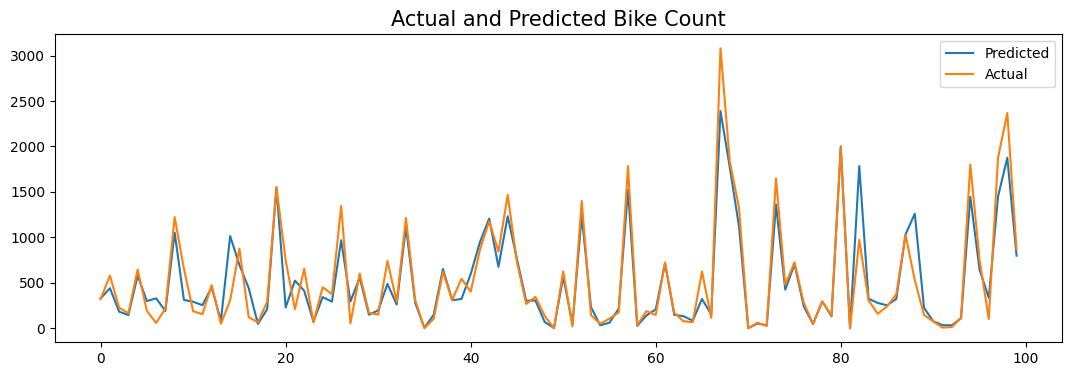

In [44]:
xgb_model = xgb.XGBRegressor(random_state=0,
                             objective='reg:squarederror')

# Fit the Extreme Gradient Boosting model to the training data
xgb_model.fit(X_train,y_train)

# Predict on the model
y_pred_xgb1 = xgb_model.predict(X_test)


result = evaluate_model(xgb_model, y_test,y_pred_xgb1)
score['Extreme Gradient Boosting Regressor'] = result

In [45]:
score

,Linear regression,Lasso regression,Lasso with alpha = 0.001,Ridge,Decision tree,Random forest,Gradient Boosting Regressor,Extreme Gradient Boosting Regressor
MSE,166184.047702,225773.503954,166245.274573,166267.268146,92450.111368,52450.499565,61963.358553,51019.383683
RMSE,407.656777,475.156294,407.731866,407.758836,304.056099,229.020740,248.924403,225.874708
MAE,274.777324,328.478754,274.758890,274.758953,175.419060,139.228058,154.949261,136.826928
Train R2,0.589962,0.445538,0.589771,0.589694,0.999998,0.982787,0.864443,0.969568
Test R2,0.592627,0.446553,0.592477,0.592423,0.773374,0.871426,0.848107,0.874934
Adjusted R2,0.590758,0.444013,0.590607,0.590553,0.772334,0.870836,0.847410,0.874360


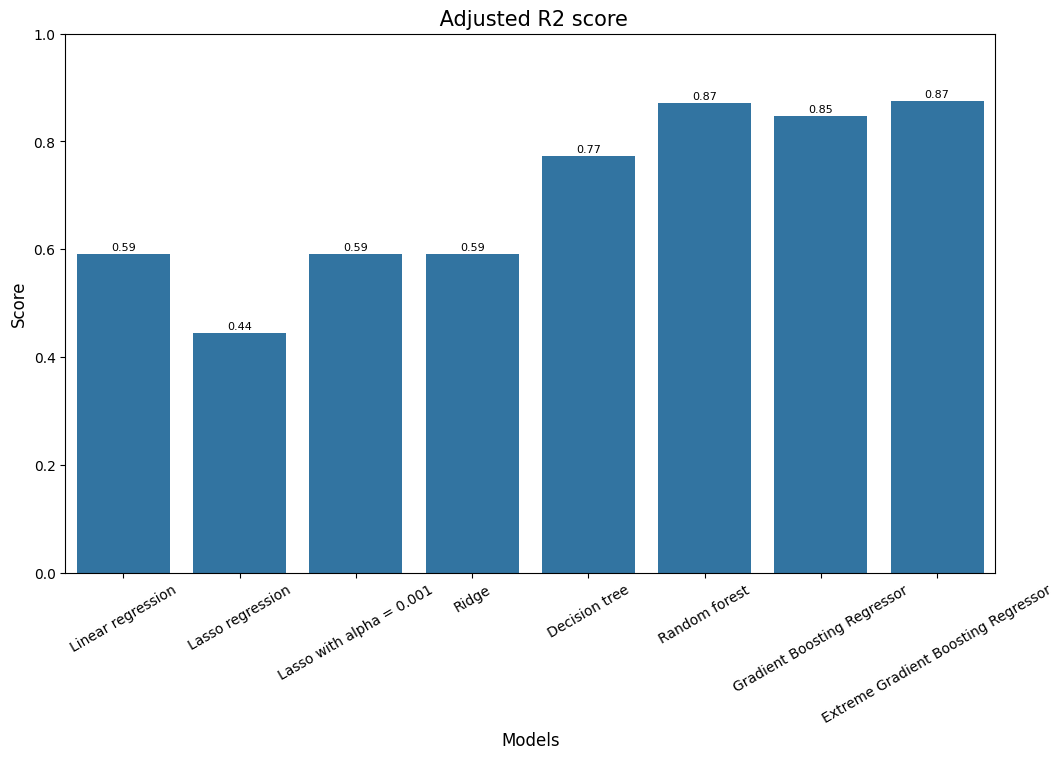

In [46]:
# Removing the overfitted models which have more than 5% gap between train and test values
score_t = score.transpose()            #taking transpose of the score dataframe to create new difference column
score_t['diff']=score_t['Train R2']-score_t['Test R2']                   #creating new column diff of train R2 and test R2 score

adj = score_t['Adjusted R2']                     #creating a new dataframe with required models and adjusted r2 score


# Visualizing a bar plot for adjusted R2 score
plt.figure(figsize=(12,7))
plots = sns.barplot(x=list(adj.index), y=adj)
for bar in plots.patches:
  plots.annotate(format(bar.get_height(),'.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 5),
                   textcoords='offset points')
plt.xticks(rotation=30)

plt.title(" Adjusted R2 score", fontsize = 15)
plt.xlabel('Models', fontsize = 12)
plt.ylabel('Score', fontsize = 12)

# Setting limit of the y axis from 0 to 30
plt.ylim(0,1)
plt.show()